In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-04-09 22:45:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.217.208, 2607:f8b0:4026:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.217.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-04-09 22:45:47 (139 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
predictors.shape

(15462, 10)

In [11]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))#we are subtracting 1 here because we have removed
#the last word in every sentence as label 
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
# model.add(Dense(64, input_dim=64,kernel_regularizer=Regularizers.l2(0.01),activity_regularizer=Regularizers.l1(0.01)))# A Dense Layer including regularizers)
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
adam=Adam(lr=0.01)# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')# Pick a loss function and an optimizer
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [12]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 13ms/step - loss: 6.8911 - accuracy: 0.0216
Epoch 2/100
484/484 [==============================] - 6s 13ms/step - loss: 6.5487 - accuracy: 0.0224
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.4987 - accuracy: 0.0243
Epoch 4/100
484/484 [==============================] - 6s 13ms/step - loss: 6.4104 - accuracy: 0.0256
Epoch 5/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3706 - accuracy: 0.0273
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3372 - accuracy: 0.0281
Epoch 7/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3113 - accuracy: 0.0286
Epoch 8/100
484/484 [==============================] - 6s 13ms/step - loss: 6.2896 - accuracy: 0.0303
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 6.2729 - accuracy: 0.0334
Epoch 10/100
484/484 [==============================] - 6s 13ms/step - loss: 6.242

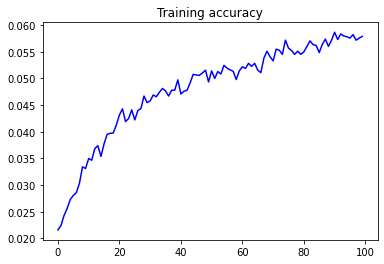

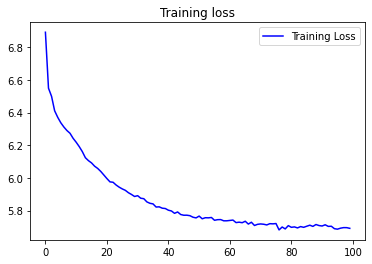

In [13]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [14]:
#outcome of the seed text without - with learning rate chosen for Adam optimizer 
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Help me Obi Wan Kenobi, you're my only hope to be i love in eyes in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye in eye


In [17]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))#we are subtracting 1 here because we have removed
#the last word in every sentence as label 
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
# model.add(Dense(64, input_dim=64,kernel_regularizer=Regularizers.l2(0.01),activity_regularizer=Regularizers.l1(0.01)))# A Dense Layer including regularizers)
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
adam=Adam()# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')# Pick a loss function and an optimizer
print(model.summary())


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_6 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [18]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 6s 13ms/step - loss: 6.8945 - accuracy: 0.0225
Epoch 2/100
484/484 [==============================] - 6s 13ms/step - loss: 6.4962 - accuracy: 0.0224
Epoch 3/100
484/484 [==============================] - 6s 13ms/step - loss: 6.3954 - accuracy: 0.0228
Epoch 4/100
484/484 [==============================] - 7s 14ms/step - loss: 6.2766 - accuracy: 0.0287
Epoch 5/100
484/484 [==============================] - 6s 13ms/step - loss: 6.1686 - accuracy: 0.0358
Epoch 6/100
484/484 [==============================] - 6s 13ms/step - loss: 6.0819 - accuracy: 0.0374
Epoch 7/100
484/484 [==============================] - 6s 13ms/step - loss: 5.9974 - accuracy: 0.0413
Epoch 8/100
484/484 [==============================] - 6s 13ms/step - loss: 5.9162 - accuracy: 0.0437
Epoch 9/100
484/484 [==============================] - 6s 13ms/step - loss: 5.8094 - accuracy: 0.0510
Epoch 10/100
484/484 [==============================] - 6s 13ms/step - loss: 5.694

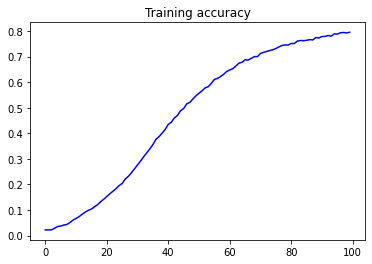

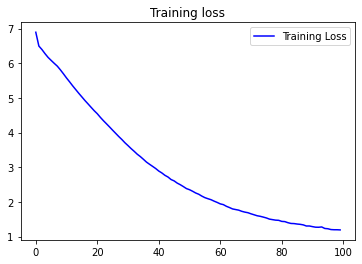

In [19]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
#outcome of the seed text without - with learning rate chosen for Adam optimizer 
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope set some place doth quite place day can spend despair in pleasure dead near alone would ye brought and short bear days arising bred another brow light light ' did brought a date part cold shows must ride none none afford afford gone saith thine eyes lies alone alone contains thee things live set so dead too substance still can ride 'will ' esteem are erred ' decays confounds invention die tongue rolling spent sea things rare strife strife light torn kill me are appear how are remain bow twain light afford live after spent light light did hell did


In [21]:
#outcome of the seed text without - with learning rate chosen for Adam optimizer 
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope set some place doth quite place day can spend despair


In [22]:
model = Sequential()
model.add(Embedding(total_words, 200, input_length=max_sequence_len-1))#we are subtracting 1 here because we have removed
#the last word in every sentence as label 
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
# model.add(Dense(64, input_dim=64,kernel_regularizer=Regularizers.l2(0.01),activity_regularizer=Regularizers.l1(0.01)))# A Dense Layer including regularizers)
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
adam=Adam()# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')# Pick a loss function and an optimizer
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 10, 200)           642200    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 10, 300)           421200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_8 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              5156866   
Total params: 6,542,771
Trainable params: 6,542,771
Non-trainable params: 0
____________________________________________

In [23]:
history = model.fit(predictors, label, epochs=10, verbose=1)

Epoch 1/10
484/484 [==============================] - 8s 16ms/step - loss: 6.9085 - accuracy: 0.0200
Epoch 2/10
484/484 [==============================] - 7s 15ms/step - loss: 6.4981 - accuracy: 0.0228
Epoch 3/10
484/484 [==============================] - 7s 15ms/step - loss: 6.3632 - accuracy: 0.0255
Epoch 4/10
484/484 [==============================] - 8s 16ms/step - loss: 6.2421 - accuracy: 0.0291
Epoch 5/10
484/484 [==============================] - 8s 16ms/step - loss: 6.1546 - accuracy: 0.0338
Epoch 6/10
484/484 [==============================] - 7s 15ms/step - loss: 6.0817 - accuracy: 0.0383
Epoch 7/10
484/484 [==============================] - 8s 16ms/step - loss: 5.9970 - accuracy: 0.0415
Epoch 8/10
484/484 [==============================] - 7s 15ms/step - loss: 5.9158 - accuracy: 0.0462
Epoch 9/10
484/484 [==============================] - 7s 15ms/step - loss: 5.8243 - accuracy: 0.0512
Epoch 10/10
484/484 [==============================] - 8s 16ms/step - loss: 5.7263 - accura

In [25]:
#outcome of the seed text - with dimensions for embeddings=200 but epochs=10
# Although mapped similar words in very high dimension for the embedding layer (200) with fewer epochs to train the model
# the outcome is not that great!
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope and love to thee in thee i i love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and love and


In [26]:
model = Sequential()
model.add(Embedding(total_words, 200, input_length=max_sequence_len-1))#we are subtracting 1 here because we have removed
#the last word in every sentence as label 
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
# model.add(Dense(64, input_dim=64,kernel_regularizer=Regularizers.l2(0.01),activity_regularizer=Regularizers.l1(0.01)))# A Dense Layer including regularizers)
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
adam=Adam()# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')# Pick a loss function and an optimizer
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 10, 200)           642200    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 10, 300)           421200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_10 (Dense)             (None, 1605)              162105    
_________________________________________________________________
dense_11 (Dense)             (None, 3211)              5156866   
Total params: 6,542,771
Trainable params: 6,542,771
Non-trainable params: 0
____________________________________________

In [27]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 7s 15ms/step - loss: 6.9161 - accuracy: 0.0214
Epoch 2/100
484/484 [==============================] - 7s 15ms/step - loss: 6.4977 - accuracy: 0.0219
Epoch 3/100
484/484 [==============================] - 7s 15ms/step - loss: 6.4012 - accuracy: 0.0257
Epoch 4/100
484/484 [==============================] - 7s 15ms/step - loss: 6.2836 - accuracy: 0.0296
Epoch 5/100
484/484 [==============================] - 7s 15ms/step - loss: 6.1842 - accuracy: 0.0340
Epoch 6/100
484/484 [==============================] - 7s 15ms/step - loss: 6.1036 - accuracy: 0.0378
Epoch 7/100
484/484 [==============================] - 7s 15ms/step - loss: 6.0265 - accuracy: 0.0413
Epoch 8/100
484/484 [==============================] - 7s 15ms/step - loss: 5.9417 - accuracy: 0.0477
Epoch 9/100
484/484 [==============================] - 7s 15ms/step - loss: 5.8486 - accuracy: 0.0514
Epoch 10/100
484/484 [==============================] - 7s 15ms/step - loss: 5.733

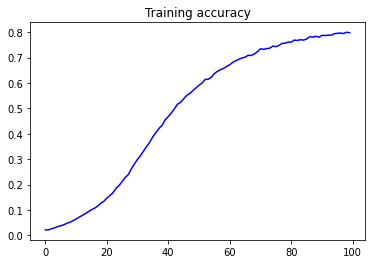

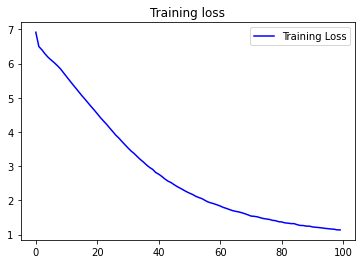

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [29]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope thy beauty enclose bear use me most love do thee where better hate age lived up thee grace my pain tell me be his part to recite his field report light ' have stand thee on me best do thee thee you best in woe rhyme last in thee men best still write not the days or days than day do thrust done true hate age gather'd still in thee hate bright age so bright ' be true prove thee bright say you go days are cold ' write of art of art forth where to know my tongue had


In [30]:
Played with a few sentences :)
seed_text = "Oh, God please help me"
next_words = 20
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Oh, God please help me yet i leave you are bright ' be grow long wantonness of me sheds go might bear youth untrue dearer


In [32]:
seed_text = "You my truest friend because"
next_words = 20
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

You my truest friend because is in thy might prove write my tongue and happy best be go night still in life hast truth by


In [34]:
# Observation: Wow, this outcome here is awesome. So training in higher dimensions cut down the noise in the mappings
# looks like. what's so cool is that the NN model understands the context a little better in higher dimensions I suppose
that the context is about love and the model predicts appropriate words like love and predicting the phrase "all things grow best to know me gladly"
# is very cool. Wow magical!

seed_text = "I can tell you my love"
next_words = 20
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

I can tell you my love and all things grow best to know me gladly see thee me thee you write not love of me than
